# Outline

* Today we will show how to train a ConvNet using PyTorch
* We will also illustrate how the ConvNet makes use of specific assumptions

# No Free Lunch Theorem

## List all the prediction problems in the universe:
* MNIST
* ImageNet
* Predict the next election
* Predict the weather on Mars
* Predict how a molecule in a far away galaxy will move
* ...
* Predict TV static
* ...


## List all the learners possible (model class + optimizer)
* 1 Layer Fully Connected Network with 10 hidden units
* 5 Layer Fully Connected Network with 1000 hidden units
* ...
* All possible ConvNets
* Rolling a dice
* ...
* Training a human expert
* ...


## On average, any algorithm will perform the same averaged over all problems

## To perform well, we need to incorporate some prior knowledge about the problem. 

* Assumptions helps us when they are true
* They hurt us when they are not
* We want to make just the right amount of assumptions, not more than that

## In Deep Learning

* Many layers: compositionality
* Convolutions: locality + stationarity of images
* Pooling: Invariance of object class to translations

In [18]:
% run plot_conf.py

In [19]:
plt_style()

In [20]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy

# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

# Load the Dataset (MNIST)


We can use some PyTorch DataLoader utilities for this.  

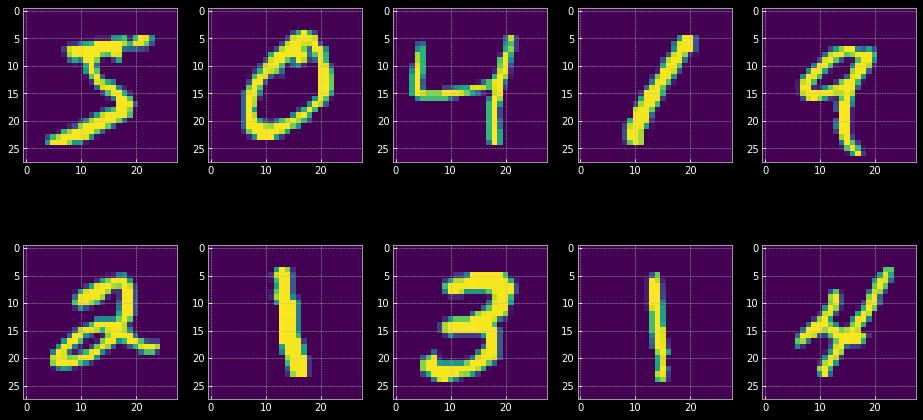

In [21]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

# show some images
plt.figure()
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())


# Create the model classes

In [22]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, output_size), 
            nn.LogSoftmax()
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)
    
    
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(1, n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)
        


    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x
 


In [23]:
accuracy_list = list()

def train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
  
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
            
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))
            
def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

# Train a small fully-connected network

In [24]:
n_hidden    = 8    # number of hidden units

model = FC2Layer(input_size, n_hidden, output_size)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model)))

for epoch in range(0, 1):
    train(epoch, model)
    test(model)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.361784


/anaconda2/envs/CodasML/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/Users/alexeys-laptop/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.915087
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.235509
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.074815
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.623851
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.569193
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.583651
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.582967
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.473697
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.429939


/Users/alexeys-laptop/.local/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



Test set: Average loss: 0.4181, Accuracy: 8785/10000 (87%)



# Train a ConvNet with the same number of parameters

In [25]:
# Training settings 
n_features    = 6     # number of feature maps

model = CNN(input_size, n_features, output_size)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model)))

for epoch in range(0, 1):
    train(epoch, model)
    test(model)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.308411


/Users/alexeys-laptop/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.496644
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.564850
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.492551
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.451262
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.110696
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.228863
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.281711
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.283849
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.132951


/Users/alexeys-laptop/.local/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



Test set: Average loss: 0.1866, Accuracy: 9445/10000 (94%)



# The ConvNet performs better with the same number of parameters, thanks to its use of prior knowledge about images

* Use of convolution: Locality and stationarity in images
* Pooling: builds in some translation invariance

# What happens if the assumptions are no longer true?


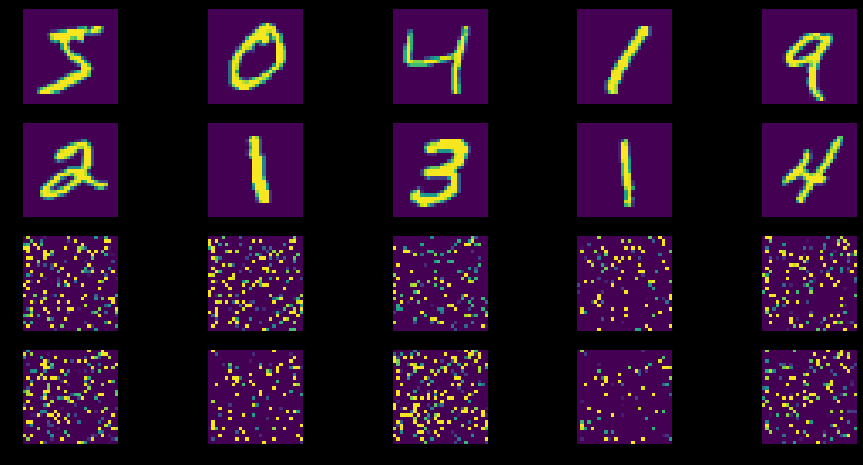

In [26]:
perm = torch.randperm(784)
plt.figure()
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    # permute pixels
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')

# ConvNet with permuted pixels

In [27]:
# Training settings 
n_features    = 6     # number of feature maps

model = CNN(input_size, n_features, output_size)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model)))

for epoch in range(0, 1):
    train(epoch, model, perm)
    test(model, perm)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.309259


/Users/alexeys-laptop/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.258301
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.125069
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.794637
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.204682
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.664493
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.812340
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.725903
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.765377
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.577911


/Users/alexeys-laptop/.local/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



Test set: Average loss: 0.5366, Accuracy: 8349/10000 (83%)



# Fully-Connected with Permuted Pixels

In [28]:
n_hidden    = 8    # number of hidden units

model = FC2Layer(input_size, n_hidden, output_size)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model)))

for epoch in range(0, 1):
    train(epoch, model, perm)
    test(model, perm)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.300587


/anaconda2/envs/CodasML/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/Users/alexeys-laptop/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.962493
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.312555
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.936838
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.698177
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.601634
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.367832
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.368634
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.331763
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.265310


/Users/alexeys-laptop/.local/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



Test set: Average loss: 0.4379, Accuracy: 8733/10000 (87%)



# The ConvNet's performance drops when we permute the pixels, but the Fully-Connected Network's performance stays the same

* ConvNet makes the assumption that pixels lie on a grid and are stationary/local
* It loses performance when this assumption is wrong
* The fully-connected network does not make this assumption
* It does less well when it is true, since it doesn't take advantage of this prior knowledge
* But it doesn't suffer when the assumption is wrong

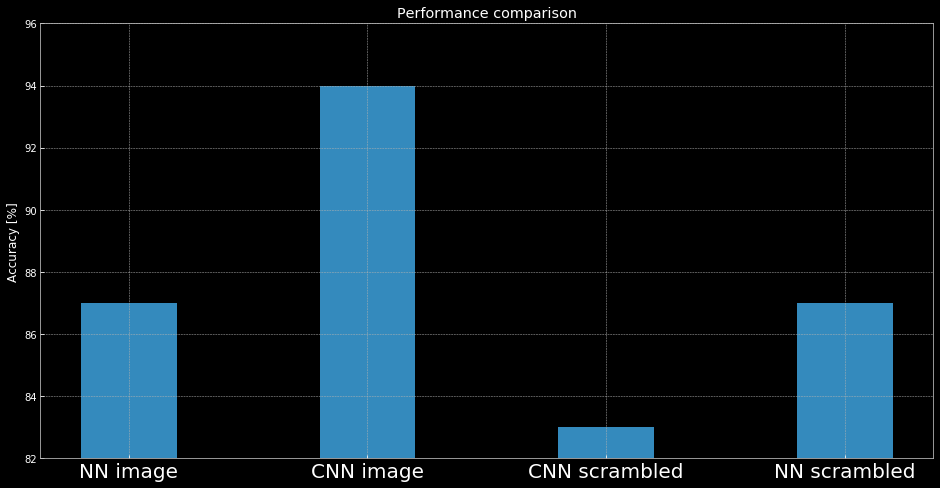

In [29]:
plt.bar(('NN image', 'CNN image',
         'CNN scrambled', 'NN scrambled'),
        accuracy_list, width=0.4)
plt.ylim((82, 96))
plt.ylabel('Accuracy [%]')
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
plt.title('Performance comparison');